The genetic evolution starts now!
Inital Breeding begins.
Inital Breeding ends.
Generation  1  completed. Best Distance:  268.526931700414


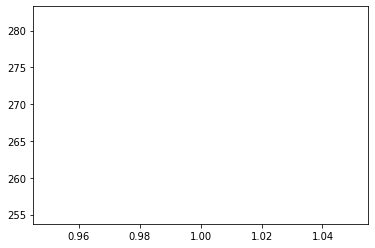

After  1  generations, we have reached the end.
The best child with distance  268.526931700414  will now be displayed.


NameError: name 'sys' is not defined

In [38]:
import pygame
from pygame.locals import *
import pymunk
import pymunk.pygame_util
from pymunk.vec2d import Vec2d
import copy
import itertools
import time
import numpy as np
import random
import statistics

import pickle

import networkx as nx

import matplotlib.pyplot as plt
    


class Game:
    
    def __init__(self):
        self.WIDTH = 600
        self.HEIGHT = 600
        
        self.DURATION = 15
        
        self.CAMERA_X = 300
        self.CAMERA_Y = 300
        
        self.MIN_CIRCLES = 3
        self.MAX_CIRCLES = 3
        
        self.DISTANCE_BETWEEN_CIRCLES = 30
        self.ROLLING_ACTIVATED = False

        # MIN always greater than 1 to avoid errors (wider than radius when drawin)
        self.MIN_RADIUS = 20
        self.MAX_RADIUS = 20

        self.MIN_MASS = 20 
        self.MAX_MASS = 100

        self.MIN_FRICTION = 0.3
        self.MAX_FRICTION = 3

        self.X_MIN = 0
        self.X_MAX = 600
        self.Y_MIN = 200
        self.Y_MAX = 400

        self.SPRING_JOINT_PROB = 0.5
        self.PIN_JOINT_PROB = 0.5

        self.MIN_REST_LENGTH = 200
        self.MAX_REST_LENGTH = 200

        self.MIN_STIFFNESS = 1000
        self.MAX_STIFFNESS = 1000

        self.MIN_DAMPNESS = 200
        self.MAX_DAMPNESS = 200

        self.MIN_RELAXED_DURATION = 50*0.1
        self.MAX_RELAXED_DURATION = 50*3

        self.MIN_STRAINED_DURATION = 50*0.1
        self.MAX_STRAINED_DURATION = 50*3
        
        self.distance = None
    
    def generate_child2(self):
        
        numberOfCircles = 3
        radius_list = [random.randint(self.MIN_RADIUS,self.MAX_RADIUS) for x in range(numberOfCircles)]
        mass_list = [self.MIN_MASS + int((self.MAX_MASS-self.MIN_MASS)*random.random()) for x in range(numberOfCircles)]
        friction_list = [self.MIN_FRICTION + int((self.MAX_FRICTION-self.MIN_FRICTION)*random.random()) for x in range(numberOfCircles)]
        position_list = [Vec2d(self.X_MIN + (self.X_MAX-self.X_MIN) * random.random(), self.Y_MIN + (self.Y_MAX-self.Y_MIN) * random.random()) for x in range(numberOfCircles)]
        
        nodes = [i for i in range(numberOfCircles)]
        
        edges = []

        for pair in itertools.combinations(nodes, r=2):

            c1 = pair[0]
            c2 = pair[1]

            edges.extend([(c1,c2,{'joint_type': 0, 'length': None,'rest_length': None,'stiffness': None,
                                  'dampness': None,'relaxed_duration': None,'strained_duration': None}),
                          (c2,c1,{'joint_type': 0, 'length': None,'rest_length': None,'stiffness': None,
                                  'dampness': None,'relaxed_duration': None,'strained_duration': None})])

        for i in range(int(len(edges)/2)):
            edge_for_values = edges[2*i]
            length = position_list[edge_for_values[0]].get_distance(position_list[edge_for_values[1]])
            rest_length = self.MIN_REST_LENGTH + (self.MAX_REST_LENGTH-self.MIN_REST_LENGTH)*random.random()
            stiffness = self.MIN_STIFFNESS + (self.MAX_STIFFNESS-self.MIN_STIFFNESS)*random.random()
            dampness = self.MIN_DAMPNESS + (self.MAX_DAMPNESS-self.MIN_DAMPNESS)*random.random()
            relaxed_duration = self.MIN_RELAXED_DURATION + int((self.MAX_RELAXED_DURATION-self.MIN_RELAXED_DURATION)*random.random())
            strained_duration = self.MIN_STRAINED_DURATION + int((self.MAX_STRAINED_DURATION-self.MIN_STRAINED_DURATION)*random.random())
            
            for j in range(2):
                edge = edges[2*i+j]
                edge[2]['length'] = length
                edge[2]['rest_length'] = rest_length
                edge[2]['stiffness'] = stiffness
                edge[2]['dampness'] = dampness
                edge[2]['relaxed_duration'] = relaxed_duration
                edge[2]['strained_duration'] = strained_duration

        return [numberOfCircles,radius_list,mass_list,friction_list,position_list,edges]
    
    def generate_child(self):
        
        numberOfCircles = random.randint(self.MIN_CIRCLES,self.MAX_CIRCLES)
        radius_list = [random.randint(self.MIN_RADIUS,self.MAX_RADIUS) for x in range(numberOfCircles)]
        mass_list = [self.MIN_MASS + int((self.MAX_MASS-self.MIN_MASS)*random.random()) for x in range(numberOfCircles)]
        friction_list = [self.MIN_FRICTION + int((self.MAX_FRICTION-self.MIN_FRICTION)*random.random()) for x in range(numberOfCircles)]
        
        nodes = [i for i in range(numberOfCircles)]
        
        valid_pos_configuration = False
        while not valid_pos_configuration:
            position_list = [Vec2d(self.X_MIN + (self.X_MAX-self.X_MIN) * random.random(), self.Y_MIN + (self.Y_MAX-self.Y_MIN) * random.random()) for x in range(numberOfCircles)]
            valid_pos_configuration = True
            
            for pair in itertools.combinations(nodes, r=2):
                i1 = pair[0]
                i2 = pair[1]
                
                pos1 = position_list[i1]
                pos2 = position_list[i2]
                
                r1 = radius_list[i1]
                r2 = radius_list[i2]
                
                if not (pos1.get_distance(pos2) - r1 - r2  > self.DISTANCE_BETWEEN_CIRCLES):
                    valid_pos_configuration = False
                    break
                    
        
        while True:
            edges = []
            
            for pair in itertools.combinations(nodes, r=2):

                c1 = pair[0]
                c2 = pair[1]
                
                if random.random() < self.SPRING_JOINT_PROB:
                    edges.extend([(c1,c2,{'joint_type': 0, 'length': None,'rest_length': None,'stiffness': None,
                                          'dampness': None,'relaxed_duration': None,'strained_duration': None}),
                                  (c2,c1,{'joint_type': 0, 'length': None,'rest_length': None,'stiffness': None,
                                          'dampness': None,'relaxed_duration': None,'strained_duration': None})])
                elif random.random() < self.PIN_JOINT_PROB:
                    edges.extend([(c1,c2,{'joint_type': 1, 'length': None,'rest_length': None,'stiffness': None,
                                          'dampness': None,'relaxed_duration': None,'strained_duration': None}),
                                  (c2,c1,{'joint_type': 1, 'length': None,'rest_length': None,'stiffness': None,
                                          'dampness': None,'relaxed_duration': None,'strained_duration': None})])
            
            g = nx.DiGraph()
            g.add_nodes_from(nodes)
            g.add_edges_from(edges)
            if len(edges) > 0 and nx.is_strongly_connected(g):
                #print([[edge[0],edge[1]] for edge in edges])
                break;
        
        for i in range(int(len(edges)/2)):
            edge_for_values = edges[2*i]
            length = position_list[edge_for_values[0]].get_distance(position_list[edge_for_values[1]])
            if edge_for_values[2]['joint_type'] == 0:
                rest_length = self.MIN_REST_LENGTH + (self.MAX_REST_LENGTH-self.MIN_REST_LENGTH)*random.random()
                stiffness = self.MIN_STIFFNESS + (self.MAX_STIFFNESS-self.MIN_STIFFNESS)*random.random()
                dampness = self.MIN_DAMPNESS + (self.MAX_DAMPNESS-self.MIN_DAMPNESS)*random.random()
                relaxed_duration = self.MIN_RELAXED_DURATION + int((self.MAX_RELAXED_DURATION-self.MIN_RELAXED_DURATION)*random.random())
                strained_duration = self.MIN_STRAINED_DURATION + int((self.MAX_STRAINED_DURATION-self.MIN_STRAINED_DURATION)*random.random())

            for j in range(2):
                edge = edges[2*i+j]
                edge[2]['length'] = length
                if edge_for_values[2]['joint_type'] == 0:
                    edge[2]['rest_length'] = rest_length
                    edge[2]['stiffness'] = stiffness
                    edge[2]['dampness'] = dampness
                    edge[2]['relaxed_duration'] = relaxed_duration
                    edge[2]['strained_duration'] = strained_duration

        return [numberOfCircles,radius_list,mass_list,friction_list,position_list,edges]
    
    def print_child(self,child):
        numberOfCircles = child[0]
        radius_list = child[1]
        mass_list = child[2]
        friction_list = child[3]
        position_list = child[4]
        edges = child[5]
        
        print("------------ Child description --------------")
        print("Number of Circles: ", numberOfCircles)
        print("Radius List: ", radius_list)
        print("Mass List: ", mass_list)
        print("Friction List: ", friction_list)
        print("Position List: ", position_list)
        print("Joints Description")
        print("\tNumber of joints: ", len(edges)/2)
        for i in range(int(len(edges)/2)):
            edge = edges[i*2]
            if edge[2]['joint_type'] == 0:
                print("\tCircle ", edge[0], " and Circle ", edge[1], "are connected with spring.")
                print("\t\tLength of connection is ", edge[2]['length'])
                print("\t\tRest length of spring is ", edge[2]['rest_length'])
                print("\t\tStiffness of spring is ", edge[2]['stiffness'])
                print("\t\tDampness of spring is ", edge[2]['dampness'])
                print("\t\tRelaxed Duration of spring is ", edge[2]['relaxed_duration'])
                print("\t\tStrained Duration of spring is ", edge[2]['strained_duration'])
            else:
                print("\tCircle ", edge[0], " and Circle ", edge[1], "are connected with pin.")
                print("\t\tLength of connection is ", edge[2]['length'])
                
        #print(edges)
        print("------------------------------------------------")
    
    def createRandomMachine(self,space, child=[]):
        
        if child == []:
            child = generate_child()

        numberOfCircles = child[0]
        radius_list = child[1]
        mass_list = child[2]
        friction_list = child[3]
        position_list = child[4]
        edges = child[5]

        circles = [self.Circle(space,position_list[i],radius_list[i],mass_list[i],friction_list[i],self.ROLLING_ACTIVATED) for i in range(numberOfCircles)]
        spring_joints = []
        pin_joints = []
        for i in range(int(len(edges)/2)):
            edge = edges[2*i]
            
            c1 = circles[edge[0]]
            c2 = circles[edge[1]]

            if edge[2]['joint_type'] == 0:
                rest_length = edge[2]['rest_length']
                stiffness = edge[2]['stiffness']
                dampness = edge[2]['dampness']
                relaxed_duration = edge[2]['relaxed_duration']
                strained_duration = edge[2]['strained_duration']
                spring_joints.append(self.SpringJoint(space,c1.body, c2.body, rest_length, stiffness,dampness, relaxed_duration,
                                                 strained_duration))
            else:    
                pin_joints.append(self.PinJoint(space,c1.body, c2.body))

        return circles,spring_joints,pin_joints
    
    def updateCamera(self,circles):
        min_x = circles[np.argmin(np.array([circle.body.position.x for circle in circles]))].body.position.x
        min_y = circles[np.argmin(np.array([circle.body.position.y for circle in circles]))].body.position.y
        max_x = circles[np.argmax(np.array([circle.body.position.x for circle in circles]))].body.position.x
        max_y = circles[np.argmax(np.array([circle.body.position.y for circle in circles]))].body.position.y
        
        pos = (Vec2d(min_x,max_y)+Vec2d(max_x,min_y))/2
        
        # leftmost circle is focused
            # circle_with_min_distance = np.argmin(np.array([circle.body.position.x for circle in circles]))
            # camera = circles[circle_with_min_distance]
            # pos = camera.body.position

        return Vec2d(pos.x - self.CAMERA_X, pos.y-self.CAMERA_Y)
    
    def simulatePhysics(self,child):
        
        FPS = 50
        
        space = pymunk.Space()
        space.gravity = (0.0, -900.0)
        #-----------------------------------------------------------------
        lines = []
        lines.append(self.add_static_L(space,0,100))
        circles,spring_joints,pin_joints = self.createRandomMachine(space,child)
        #-----------------------------------------------------------------
        #lines = []
        #circles = []
        #joints = []
         
        maxStep = FPS * self.DURATION
        
        for currentStep in range(maxStep):
            
            for joint in spring_joints:
                joint.strain_countdown()

            space.step(1/FPS)
        
        self.distance = max([circle.body.position.x for circle in circles])-600
            
    def start(self,child = [], DRAW_DEBUG = True):
    
        pygame.init()
        screen = pygame.display.set_mode((self.WIDTH, self.HEIGHT))
        myfont = pygame.font.SysFont('Comic Sans MS', 30)
        distance_marker_font = pygame.font.SysFont('Comic Sans MS', 10)
        pygame.display.set_caption("Game Simulation")
        clock = pygame.time.Clock()
        
        distance_marker = [100*(i+1) for i in range(20)]

        draw_options = pymunk.pygame_util.DrawOptions(screen)

        space = pymunk.Space()
        
        if self.FLYING_ALLOWED:
            coll_handler = space.add_collision_handler(1,2)
            coll_handler._set_begin()
        
        space.gravity = (0.0, -900.0)

        lines = []
        lines.append(self.add_static_L(space,0,100))
        
        if child == []:
            child = generate_child()
        
        circles,spring_joints,pin_joints = self.createRandomMachine(space,child)
        
        t1 = time.time()

        startTime = pygame.time.get_ticks()
        
        while True:
            currentDistance = max([circle.body.position.x for circle in circles])-600
            # -------------------------------------- GAME ENDS --------------------------------------
            t2 = time.time()
            if(t2-t1 >= self.DURATION):

                self.distance = currentDistance

                break;
            # ----------------------------------------------------------------------------------------
            
            for event in pygame.event.get():
                if event.type == QUIT:
                    pygame.quit()
                    sys.exit(0)
                elif event.type == KEYDOWN and event.key == K_ESCAPE:
                    sys.exit(0)

            for joint in spring_joints:
                joint.strain_countdown()

            space.step(1/50.0)

            screen.fill((255,255,255))

            cam_diff = self.updateCamera(circles)
            
            if DRAW_DEBUG:
                space.debug_draw(draw_options)
            else:
                # manual update
                for marker in distance_marker:
                    self.drawVerticalLine(screen,distance_marker_font,cam_diff,600+marker,color=(0,255,0,0))
                self.updateLines(screen,lines,cam_diff)
                self.updateCircles(screen,circles,cam_diff)
                self.updateJoints(screen,child[5],circles,cam_diff)

            # display timer
            currentTime = pygame.time.get_ticks()
            timer = myfont.render(str((currentTime-startTime)/1000), False, (0, 0, 0))
            screen.blit(timer,(0,0))
            
            #display distance
            distance_display = myfont.render(str(int(currentDistance)), False, (0, 0, 0))
            screen.blit(distance_display,(400,0))
            
            
            pygame.display.flip()
            clock.tick(50)
        
        pygame.quit()
        
    def check_child_flying(arbiter,space,data):
        
        
        
    
    def add_static_L(self,space,x_body,y_body, length=20000,col=(0,255,0,0)):
        offset = -10000
        return self.Segment(pymunk.Body.STATIC,space, (offset,100), (length-offset,0), radius=10,color=col)

    class Segment:
        def __init__(self,b_type,space, p0, v, radius=10,color=(0, 255, 0, 0)):
            self.body = pymunk.Body(body_type=b_type)
            self.body.position = p0

            self.shape = pymunk.Segment(self.body, (0, 0), v, radius)
            self.shape.density = 0.1
            self.shape.elasticity = 0.5
            self.shape.friction = 1
            self.shape.mass = 1000
            #self.shape.filter = pymunk.ShapeFilter(group=1)
            self.shape.color = color
            
            
            self.shape._set_collision_type(1)
            
            if space is not None:
                space.add(self.body, self.shape)

    class Circle:
        def __init__(self, space,pos, radius=20, mass = 1, friction = 0.9, rolling_activated =True):

            if rolling_activated:
                moment_of_inertia = pymunk.moment_for_circle(mass, 0, radius)
            else:
                moment_of_inertia = pymunk.inf
            self.body = pymunk.Body(mass, moment_of_inertia)
            self.body.position = pos

            self.shape = pymunk.Circle(self.body, radius)
            #self.shape.density = 0.01
            self.shape.friction = friction
            self.shape.elasticity = 1

            self.shape.color = (150, 200, 40, 0)
            
            self.shape._set_collision_type(2)

            if space is not None:
                space.add(self.body, self.shape)
                
    class PinJoint:
        def __init__(self, space,b, b2, a=(0, 0), a2=(0, 0),i1=-1,i2=-1):
            self.joint = pymunk.PinJoint(b, b2, a, a2)

            if space is not None:
                space.add(self.joint)

    class SpringJoint:
        def __init__(self, space,b, b2, rest_length,stiffness,dampness ,relaxed_duration,strained_duration,a=(0, 0), a2=(0, 0), i1=-1,i2=-1):        
            self.joint = pymunk.DampedSpring(b, b2, a, a2, rest_length,stiffness, dampness)
            self.relaxed_duration = relaxed_duration
            self.strained_duration = strained_duration
            self.state = "relaxed"
            self.current_tick = 0
            self.init_rest_length = rest_length
            self.init_stiffness = stiffness

            if space is not None:
                space.add(self.joint)
                
        def strain_countdown(self):
            #print(str(self.current_tick),", ",self.state)
            if self.state == "relaxed":
                if self.relaxed_duration == self.current_tick:
                    self.current_tick = 0
                    self.state = "strained"
                    self.joint._set_rest_length(1)
                    #self.joint._set_rest_length(10*self.init_rest_length)
                    #self.joint._set_stiffness(self.init_stiffness/10)
            else:
                if self.strained_duration == self.current_tick:
                    self.current_tick = 0
                    self.state = "relaxed"
                    self.joint._set_rest_length(self.init_rest_length) 
                    #self.joint._set_rest_length(self.init_rest_length/10)
                    #self.joint._set_stiffness(10*self.init_stiffness
            self.current_tick += 1

    def updateLines(self,screen,lines,camera):

        for line in lines:
            shape = line.shape
            body = line.body
            new_body_pos = body.position - camera

            pv1 = new_body_pos + shape.a.rotated(body.angle)
            pv2 = new_body_pos + shape.b.rotated(body.angle)

            p1 = pv1.x, -pv1.y+600
            p2 = pv2.x, -pv2.y+600

            #print(pv1,pv2)
            #print(p1,p2)
            #print(camera)
            #print("-----------")
            pygame.draw.lines(screen, shape.color, False, [p1,p2], int(2*shape.radius))
        #print("----FINISH--")

    def drawVerticalLine(self,screen,font,camera,lineDistance,color=(0,255,0,0)):

        p1 = Vec2d(lineDistance,100) - camera
        p2 = Vec2d(lineDistance,300) - camera

        p1 = Vec2d(p1.x,600-p1.y)
        p2 = Vec2d(p2.x,600-p2.y)

        draw_x = p1.x

        #print(p1,p2,"It should be visible on screen")
        if draw_x >= 0 and draw_x <= 600:
            pygame.draw.lines(screen, color, False, [p1,p2], 5)
            distance_marker_display = font.render(str(lineDistance-600), False, (0, 0, 0))
            screen.blit(distance_marker_display,p2)

    def updateJoints(self,screen,edges,circles,camera):

        for i in range(int(len(edges)/2)):
            edge = edges[2*i]
            
            c1 = circles[edge[0]]
            c2 = circles[edge[1]]

            #print("update Joints: ",joint.i1,joint.i2)

            c1_pos = c1.body.position - camera
            c2_pos = c2.body.position - camera

            p1 = c1_pos.x, -c1_pos.y+600
            p2 = c2_pos.x, -c2_pos.y+600

            #print("update Joints: ",p1,p2)

            if edge[2]['joint_type'] == 0:
                color=(255,0,0)
            else:
                color=(0,0,255)
            
            pygame.draw.lines(screen, color, False, [p1,p2], 5)

    def updateCircles(self,screen,circles,camera):

        for circle in circles:
            #print("update Circles: ",circle.body.position)

            shape = circle.shape
            body = circle.body
            v = body.position
            r = shape.radius
            rot = body.rotation_vector

            new_body_pos = body.position - camera
            p2 = Vec2d(rot.x, rot.y) * r * 0.9

            # width is 2, radius should always be greater than width
            pygame.draw.circle(screen, shape.color, (int(new_body_pos.x), int(-new_body_pos.y+600)), int(r), 2)

            startPoint = new_body_pos
            endPoint = new_body_pos+p2
            pygame.draw.line(screen, (255,0,0), Vec2d(startPoint.x,-startPoint.y+600), Vec2d(endPoint.x,-endPoint.y+600))

            #print("update Circles: ",new_body_pos)
            #print(pv1,pv2)
            #print(p1,p2)
            #print(camera)
            #print("-----------")
        #print("----FINISH--")

#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------------

class Genetic_Algorithm:
    def __init__(self,gen_limit=1000,lowest_best=False,pop_limit=1000,kill_rate=0.5,reprod_rate=0.3,clone_rate=0):
        self.game = Game()
        
        self.species = []
        self.children_with_distances_over_2000 = []
        self.distances_over_2000 = []
        
        self.LOWEST_FITNESS_IS_BEST = lowest_best
        self.GENERATION_LIMIT = gen_limit
        self.POPULATION_LIMIT = pop_limit
        self.KILL_RATE = kill_rate
        self.REPRODUCTION_RATE = reprod_rate
        self.CLONE_PROB = clone_rate
        
        self.MIN_RADIUS_DIFF = -1
        self.MAX_RADIUS_DIFF = 1

        self.MIN_MASS_DIFF = -1
        self.MAX_MASS_DIFF = 1

        self.MIN_FRICTION_DIFF = -0.1
        self.MAX_FRICTION_DIFF = 0.1
 
        self.MIN_X_DIFF = -5
        self.MAX_X_DIFF = 5
        self.MIN_Y_DIFF = -5
        self.MAX_Y_DIFF = 5

        self.MIN_REST_LENGTH_DIFF = 0
        self.MAX_REST_LENGTH_DIFF = 0

        self.MIN_STIFFNESS_DIFF = 0
        self.MAX_STIFFNESS_DIFF = 0

        self.MIN_DAMPNESS_DIFF = 0
        self.MAX_DAMPNESS_DIFF = 0

        self.MIN_RELAXED_DURATION_DIFF = -50*0.1
        self.MAX_RELAXED_DURATION_DIFF = 50*0.1

        self.MIN_STRAINED_DURATION_DIFF = -50*0.1
        self.MAX_STRAINED_DURATION_DIFF = 50*0.1
    
    def fitness_function(self,child):
        self.game.simulatePhysics(child)
        return self.game.distance
    
    def undo_border_crossing(self,lower_bound,upper_bound,value):
        if value < lower_bound:
            return lower_bound
        elif value > upper_bound:
            return upper_bound
        else:
            return value
    
    def mutate(self,child):
        
        numberOfCircles = child[0]
    
        child[1] = [self.undo_border_crossing(self.game.MIN_RADIUS,self.game.MAX_RADIUS,radius+(self.MIN_RADIUS_DIFF + (self.MAX_RADIUS_DIFF-self.MIN_RADIUS_DIFF)*random.random())) for radius in child[1]]
        radius_list = child[1]
        
        child[2] = [self.undo_border_crossing(self.game.MIN_MASS,self.game.MAX_MASS,mass+(self.MIN_MASS_DIFF + (self.MAX_MASS_DIFF-self.MIN_MASS_DIFF)*random.random())) for mass in child[2]]
        mass_list = child[2]
        
        child[3] = [self.undo_border_crossing(self.game.MIN_FRICTION,self.game.MAX_FRICTION,friction+(self.MIN_FRICTION_DIFF + (self.MAX_FRICTION_DIFF-self.MIN_FRICTION_DIFF)*random.random())) for friction in child[3]]
        friction_list = child[3]
        
        nodes = [i for i in range(numberOfCircles)]
        
        valid_pos_configuration = False
        while not valid_pos_configuration:
            pos_list = [Vec2d(self.undo_border_crossing(self.game.X_MIN,self.game.X_MAX,position.x+(self.MIN_X_DIFF + (self.MAX_X_DIFF-self.MIN_X_DIFF)*random.random())),self.undo_border_crossing(self.game.Y_MIN,self.game.Y_MAX,position.y+(self.MIN_Y_DIFF + (self.MAX_Y_DIFF-self.MIN_Y_DIFF)*random.random()))) for position in child[4]]
            valid_pos_configuration = True
            
            for pair in itertools.combinations(nodes, r=2):
                i1 = pair[0]
                i2 = pair[1]
                
                pos1 = pos_list[i1]
                pos2 = pos_list[i2]
                
                r1 = radius_list[i1]
                r2 = radius_list[i2]
                
                if not (pos1.get_distance(pos2) - r1 - r2  > self.game.DISTANCE_BETWEEN_CIRCLES):
                    valid_pos_configuration = False
                    break
        
        child[4] = pos_list
        position_list = child[4]
        
        edges = child[5]
        
        # maybe remove joints
        while True:
            new_edges = []
            for i in range(int(len(edges)/2)):
                if random.random() < 0.75:
                    new_edges.extend([edges[2*i],edges[2*i+1]])
            g = nx.DiGraph()
            g.add_nodes_from(nodes)
            g.add_edges_from(new_edges)
            if len(new_edges) > 0 and nx.is_strongly_connected(g):
                break;
        
        old_pairs = [(new_edges[2*i][0],new_edges[2*i][1]) for i in range(int(len(new_edges)/2))]
        remaining_pairs = [pair for pair in itertools.combinations(nodes, r=2) if pair not in old_pairs]
        for pair in remaining_pairs:
            c1 = pair[0]
            c2 = pair[1]
            if random.random() > 0.75:
                new_edges.extend([(c1,c2,{'joint_type': None, 'length': None,'rest_length': None,'stiffness': None,
                                          'dampness': None,'relaxed_duration': None,'strained_duration': None}),
                                  (c2,c1,{'joint_type': None, 'length': None,'rest_length': None,'stiffness': None,
                                          'dampness': None,'relaxed_duration': None,'strained_duration': None})])
        child[5] = new_edges
        edges = child[5]
        
        # change joint_type
        for i in range(int(len(edges)/2)):
            edge_for_values = edges[2*i]
            
            old_joint_type = edge_for_values[2]['joint_type']
            new_joint_type = random.randint(0,1)
            joint_type_changed = (not old_joint_type == new_joint_type) or old_joint_type == None 
            
            joint_length = position_list[edge_for_values[0]].get_distance(position_list[edge_for_values[1]])
            #--------------------------------------------------------
            if joint_type_changed and new_joint_type == 0:
                
                rest_length = self.game.MIN_REST_LENGTH + (self.game.MAX_REST_LENGTH-self.game.MIN_REST_LENGTH)*random.random()
                stiffness = self.game.MIN_STIFFNESS + (self.game.MAX_STIFFNESS-self.game.MIN_STIFFNESS)*random.random()
                dampness = self.game.MIN_DAMPNESS + (self.game.MAX_DAMPNESS-self.game.MIN_DAMPNESS)*random.random()
                relaxed_duration = self.game.MIN_RELAXED_DURATION + int((self.game.MAX_RELAXED_DURATION-self.game.MIN_RELAXED_DURATION)*random.random())
                strained_duration = self.game.MIN_STRAINED_DURATION + int((self.game.MAX_STRAINED_DURATION-self.game.MIN_STRAINED_DURATION)*random.random())
                
                for j in range(2):
                    edge = edges[2*i+j]
                    edge[2]['joint_type'] = new_joint_type
                    edge[2]['length'] = joint_length
                    edge[2]['rest_length'] = rest_length
                    edge[2]['stiffness'] = stiffness
                    edge[2]['dampness'] = dampness
                    edge[2]['relaxed_duration'] = relaxed_duration
                    edge[2]['strained_duration'] = strained_duration
                
            elif joint_type_changed and new_joint_type == 1:
                
                for j in range(2):
                    edge = edges[2*i+j]
                    edge[2]['joint_type'] = new_joint_type
                    edge[2]['length'] = joint_length
                    edge[2]['rest_length'] = None
                    edge[2]['stiffness'] = None
                    edge[2]['dampness'] = None
                    edge[2]['relaxed_duration'] = None
                    edge[2]['strained_duration'] = None
                    
            elif (not joint_type_changed) and new_joint_type == 0:
                
                rest_length = self.undo_border_crossing(self.game.MIN_REST_LENGTH,self.game.MAX_REST_LENGTH,edge_for_values[2]['rest_length']+(self.MIN_REST_LENGTH_DIFF + (self.MAX_REST_LENGTH_DIFF-self.MIN_REST_LENGTH_DIFF)*random.random()))
                stiffness = self.undo_border_crossing(self.game.MIN_STIFFNESS,self.game.MAX_STIFFNESS,edge_for_values[2]['stiffness']+(self.MIN_STIFFNESS_DIFF + (self.MAX_STIFFNESS_DIFF-self.MIN_STIFFNESS_DIFF)*random.random()))
                dampness = self.undo_border_crossing(self.game.MIN_DAMPNESS,self.game.MAX_DAMPNESS,edge_for_values[2]['dampness']+(self.MIN_DAMPNESS_DIFF + (self.MAX_DAMPNESS_DIFF-self.MIN_DAMPNESS_DIFF)*random.random()))
                relaxed_duration = self.undo_border_crossing(self.game.MIN_RELAXED_DURATION,self.game.MAX_RELAXED_DURATION,edge_for_values[2]['relaxed_duration']+(self.MIN_RELAXED_DURATION_DIFF + (self.MAX_RELAXED_DURATION_DIFF-self.MIN_RELAXED_DURATION_DIFF)*random.random()))
                strained_duration = self.undo_border_crossing(self.game.MIN_STRAINED_DURATION,self.game.MAX_STRAINED_DURATION,edge_for_values[2]['strained_duration']+(self.MIN_STRAINED_DURATION_DIFF + (self.MAX_STRAINED_DURATION_DIFF-self.MIN_STRAINED_DURATION_DIFF)*random.random()))
                
                for j in range(2):
                    edge = edges[2*i+j]
                    edge[2]['length'] = joint_length
                    edge[2]['rest_length'] = rest_length
                    edge[2]['stiffness'] = stiffness
                    edge[2]['dampness'] = dampness
                    edge[2]['relaxed_duration'] = relaxed_duration
                    edge[2]['strained_duration'] = strained_duration
            else:
                
                for j in range(2):
                    edge = edges[2*i+j]
                    edge[2]['length'] = joint_length
            
        return None
    
    def breed_population(self,population,breed_count,clone_prob, prob_list):
        #print("---Breeding starts now:---------")
        prob = prob_list
        indeces = [i for i in range(len(population))]
        for i in range(breed_count):
            parent_indeces = np.random.choice(indeces,1,p=prob,replace=False)
            parent1 = population[parent_indeces[0]]
            child = copy.deepcopy(parent1)
            if random.random() > clone_prob:
                self.mutate(child)
            #print("Mutated Child is: ", convert_to_string(child))
            population.append(child)
        #print("------Breeding has ended-------")
    
    # ---------------------------------------- ---------------------------
    

    def generate_population(self,population_size):  
        return [self.game.generate_child() for pop in range(population_size)]
    
    def kill_population(self,population,survivor_count,prob_list):
        prob = prob_list 
        t1 = time.time()
        rest_population_indeces = np.random.choice([i for i in range(len(population))], survivor_count, p=prob, replace=False)  
        rest_population = [population[rest_population_indeces[i]] for i in range(len(rest_population_indeces))]
        t2 = time.time()
        #print(str(t2-t1))
        return rest_population, rest_population_indeces

    def get_survival_probability(self,fitness_scores):
        fitness_list = fitness_scores

        mean = statistics.mean(fitness_list)
        stdev = statistics.stdev(fitness_list)
        normalized_fitness_list = [(fitness-mean)/stdev for fitness in fitness_list]

        if self.LOWEST_FITNESS_IS_BEST:
            changed_order_fitness_list = [np.e**(-fitness) for fitness in normalized_fitness_list]
        else:
            changed_order_fitness_list = [np.e**(fitness) for fitness in normalized_fitness_list]

        fitness_sum = sum(changed_order_fitness_list)
        prob_list = [fitness/fitness_sum for fitness in changed_order_fitness_list]

        return prob_list
    
    def classify_children(self,children, gen_count, fitness_list):
        
        result = []
        
        def edges_equal(e1,e2):
            return (e1['joint_type'] ==  e2['joint_type'])
            
            #return (e1['joint_type'] ==  e2['joint_type'] and e1['length'] ==  e2['length'] and
            #        e1['rest_length'] ==  e2['rest_length'] and e1['stiffness'] ==  e2['stiffness'] and
            #        e1['dampness'] ==  e2['dampness'] and e1['relaxed_duration'] ==  e2['relaxed_duration'] and
            #        e1['strained_duration'] ==  e2['strained_duration'])

        indeces = [i for i in range(len(children))]
        graphs = []
        t1 = time.time()
        for child in children:
            nodes = [i for i in range(child[0])]
            edges = child[5]
            g = nx.DiGraph()
            g.add_nodes_from(nodes)
            g.add_edges_from(edges)
            graphs.append(g)
        t2 = time.time()
        #print(str(t2-t1))
        #print("Already discovered species are used:")
        #print("this is the indeces list: ", indeces)
        t1 = time.time()
        for i in range(len(self.species)):
            fitness_of_current_species = []
        #    print("This species is used: ", self.species[i])
            new_species_count = 0
            indeces_to_remove = []
            ancestor = self.species[i][2]
            for j in indeces:
                descendant = graphs[j]
                if nx.graph_edit_distance(ancestor, descendant, edge_match=edges_equal) == 0:
                    new_species_count += 1
                    indeces_to_remove.append(j)
        #    print(new_species_count, "belong to the same species.")
        #    print("Hihih")
        #    print(len(self.species))
        #    print(len(self.species[i]))
            self.species[i][3].append((gen_count,new_species_count))
            
            for j in indeces_to_remove:
                indeces.remove(j)
                fitness_of_current_species.append(fitness_list[j])
            if len(fitness_of_current_species) > 0:
                best_child_of_species_index = indeces_to_remove[np.argmax(np.array(fitness_of_current_species))]
                if fitness_list[best_child_of_species_index] > self.species[i][1]:
                    self.species[i][0] = children[best_child_of_species_index]
                    self.species[i][1] = fitness_list[best_child_of_species_index]
                    self.species[i][2] = graphs[best_child_of_species_index]
                    self.species[i][4] = best_child_of_species_index+gen_count*self.POPULATION_LIMIT
         #       print("These are the indeces to remove: ", indeces_to_remove)
         #   print("this is the indeces list after removing", new_species_count," children: ", indeces)
        
        #print("New species will now be discovered:")
        #print("this is the indeces list: ", indeces)
        t2 = time.time()
        #print(str(t2-t1))
        
        t1 = time.time()
        while not indeces == []:
            fitness_of_current_species = []
            index = indeces[0]
            species_count = 1
            indeces.pop(0)
            self.species.append([children[index],fitness_list[index],graphs[index],[(i,0) for i in range(gen_count)],index+gen_count*self.POPULATION_LIMIT])
            indeces_to_remove = []
    
            ancestor = graphs[index]

        
            t2 = time.time()
            for i in indeces:
                descendant = graphs[i]
                
                temp = None
                for score in nx.optimize_graph_edit_distance(ancestor, descendant, edge_match=edges_equal): 
                    temp = score
                if temp == 0:
                
                #if nx.optimal_edit_paths(ancestor, descendant, edge_match=edges_equal)[-1] == 0:
                
                #if nx.graph_edit_distance(ancestor, descendant, edge_match=edges_equal) == 0:
                    species_count += 1
                    indeces_to_remove.append(i)
        
            t3 = time.time()
        #    print(str(t3-t2))
        #    print(species_count, "belong to the same species.")
            self.species[-1][3].append((gen_count,species_count))
            
        #    print("These are the indeces to remove: ", indeces_to_remove)
            temp = [children[index]]
            for i in indeces_to_remove:
                temp.append(children[i])
                indeces.remove(i)
                fitness_of_current_species.append(fitness_list[i])
            result.append(temp)
            if len(fitness_of_current_species) > 0:
                best_child_of_species_index = indeces_to_remove[np.argmax(np.array(fitness_of_current_species))]
                if fitness_list[best_child_of_species_index] > self.species[-1][1]:
                    self.species[-1][0] = children[best_child_of_species_index]
                    self.species[-1][1] = fitness_list[best_child_of_species_index]
                    self.species[-1][2] = graphs[best_child_of_species_index]
                    self.species[-1][4] = best_child_of_species_index+gen_count*self.POPULATION_LIMIT

        #    print("this is the indeces list after removing", species_count," children: ", indeces)
        t2 = time.time()
        #print(str(t2-t1))
        
        return result
        
            
            
    def start(self):

        print("The genetic evolution starts now!")
        
        t1 = time.time()
        survivor_count = int(self.POPULATION_LIMIT * (1-self.KILL_RATE))
        breed_count = int(self.POPULATION_LIMIT * self.REPRODUCTION_RATE)

        print("Inital Breeding begins.")
        population = self.generate_population(self.POPULATION_LIMIT)
        print("Inital Breeding ends.")
        
        best_distances = []
        best_children = []

        x_data = [i+1 for i in range(self.GENERATION_LIMIT)]
        y_data = best_distances
        t2 = time.time()
        #print("Initialization takes ", str(t2-t1), " seconds.")
        for generations_count in range(self.GENERATION_LIMIT):
            #population = self.generate_population(self.POPULATION_LIMIT)
            #fitness_list = [self.fitness_function(child) for child in population]
            #t1 = time.time()
            #result = self.classify_children(population,generations_count,fitness_list)
            #t2 = time.time()
            #print("Classifying population takes ", str(t2-t1), " seconds.")
            #continue
            exec_time_per_gen = 0
            
            # ---------------------------------------- Sorting population and its fitness-----------------------------------------
            t1 = time.time()
            fitness_list = [self.fitness_function(child) for child in population]
            prob_list = self.get_survival_probability(fitness_list)
            best_child_index = np.argmax(np.array(fitness_list))
            best_child = population[best_child_index]
            best_distance = fitness_list[best_child_index]
            for i in range(len(population)):  
                if fitness_list[i] > 2000 and (fitness_list[i] not in self.distances_over_2000):
                    self.children_with_distances_over_2000.append(population[i])
                    self.distances_over_2000.append(fitness_list[i])
                    
            t2 = time.time()
            exec_time_per_gen += t2-t1
            #print("Sorting fitness and population takes ", str(t2-t1), " seconds.")
            
            
            t1 = time.time()
            #result = self.classify_children(population,generations_count,fitness_list)
            t2 = time.time()
            #print("Classifying population takes ", str(t2-t1), " seconds.")

            
            t1 = time.time()
            [rest_population, rest_population_indeces] = self.kill_population(population,survivor_count,prob_list)
            t2 = time.time()
            exec_time_per_gen += t2-t1
            #print("Killing the population takes ", str(t2-t1), " seconds.")
            #print("After killing, this is the rest population: ", [convert_to_string(child) for child in rest_population])
            t1 = time.time()
            prob_list = self.get_survival_probability([fitness_list[i] for i in rest_population_indeces])
            self.breed_population(rest_population,breed_count,self.CLONE_PROB, prob_list)
            t2 = time.time()
            exec_time_per_gen += t2-t1
            #print("Breeding the population takes ", str(t2-t1), " seconds.")
            #print("After breeding, this is the rest population", [convert_to_string(child) for child in rest_population])
            t1 = time.time()
            rest_population.extend(self.generate_population(self.POPULATION_LIMIT-len(rest_population)))
            t2 = time.time()
            exec_time_per_gen += t2-t1
            #print("Extending population takes ", str(t2-t1), " seconds.")
            #print("To get to pop limit, rest has been added: ", [convert_to_string(child) for child in rest_population])
            population = rest_population
            #print("One generation takes ", exec_time_per_gen, " seconds.")
            print("Generation ", generations_count+1, " completed. Best Distance: ", str(best_distance))
            
            best_distances.append(best_distance)
            best_children.append(best_child)
            #print(fitness_list)
    
        #print("After ", str(self.GENERATION_LIMIT), " generations, we have reached the end.")
        #print("The best child with distance ",best_distances[-1], " will now be displayed.")
        #self.game.start(best_children[-1],True)
        #self.game.start(best_children[-1],False)
        #child = self.game.generate_child()
        #self.game.print_child(child)
        #self.game.start(child,True)
        #self.mutate(child)
        #self.game.print_child(child)
        #self.game.start(child,True)
        plt.plot(x_data,y_data)
        plt.show()
        
        
        
        '''
        x = [i+1 for i in range(self.GENERATION_LIMIT)]
        ys = [[pair[1] for pair in species[3]] for species in self.species]
        #print(ys)
        y = np.vstack(ys)

        labels = [str(i) for i in range(len(self.species))]

        fig, ax = plt.subplots()
        ax.stackplot(x, y, labels=labels)
        ax.legend(loc='upper left')
        plt.show()
        '''      

        print("After ", str(self.GENERATION_LIMIT), " generations, we have reached the end.")
        print("The best child with distance ",best_distances[-1], " will now be displayed.")
        self.game.start(best_children[-1],True)
        self.game.start(best_children[-1],False)
        
do_genetic_evolution = True
reset = False
load_stored_children = False
play_stored_children = True and load_stored_children


if do_genetic_evolution:
    g = Genetic_Algorithm(1,pop_limit = 1000)
    g.start()
    
    species = g.species
    distances = g.distances_over_2000
    children = g.children_with_distances_over_2000
    game = g.game

    with open("children_who_reach_more_than_2000_fitness.txt", "rb") as fp:   # Unpickling
        stored_species = pickle.load(fp)
        stored_children = [child[1] for child in stored_species]
        stored_distances = [child[0] for child in stored_species]
        children.extend(stored_children)
        distances.extend(stored_distances)
    
    g.classify_children(children,0,distances)
    
    list1 = [child[1] for child in species]
    list2 = [child[0] for child in species]
    list1, list2 = zip(*sorted(zip(list1, list2)))
    species = list(zip(list(list1),list(list2)))
    
    with open("children_who_reach_more_than_2000_fitness.txt", "wb") as fp:   #Pickling
        pickle.dump(species, fp)
    
    print("Storing done.")
    print([child[0] for child in species])

if reset:
    with open("children_who_reach_more_than_2000_fitness.txt", "wb") as fp:   #Pickling
        pickle.dump([],fp)
    print("Reset done.")

if load_stored_children:
    with open("children_who_reach_more_than_2000_fitness.txt", "rb") as fp:   #Pickling
        b = pickle.load(fp)
    print("Loading of ", len(b), " species done.")

if play_stored_children:
    print(b[-1])
    for child in b:
        game.start(child[1],False)
    print("All stored children played.")
